# 1 Cài đặt môi trường

In [1]:
import sys
import subprocess
import os

def setup_environment():
    packages = [
        "torch==2.3.0",      
        "torchtext==0.18.0",  
        "numpy<2.0",          
        "spacy"
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        except subprocess.CalledProcessError:
            print(f"Không thể cài đặt {package}. Vui lòng kiểm tra lại.")

    spacy_models = ["en_core_web_sm", "fr_core_news_sm"]
    for model in spacy_models:
        try:
            import spacy
            if not spacy.util.is_package(model):
                raise ImportError
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "spacy", "download", model])

    print("\n Cài đặt mô hình hoàn thành!")

if __name__ == "__main__":
    setup_environment()


 Cài đặt mô hình hoàn thành!


# 2 Thêm thư viện cần thiết

In [11]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import torch.optim as optim
from src.train import train_epoch, evaluate, epoch_time
import torch.nn as nn
import itertools
import torch
import time
import math
import random
import io
import spacy
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.metrics import bleu_score
sys.path.append(os.path.abspath('..'))
from src.data_loader import get_loaders
from src.model import Encoder, Decoder, Seq2Seq

# 3 khởi tạo dữ liệu

In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
path_en = '../data/raw/train.en'
path_fr = '../data/raw/train.fr'
train_loader, vocab_en, vocab_fr = get_loaders(BATCH_SIZE, path_en, path_fr)
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_fr)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            torch.nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            torch.nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

print("Đã khởi tạo xong!")

Đã khởi tạo xong!


# 4 Cấu hình huấn luyện

In [4]:

LEARNING_RATE = 0.001
N_EPOCHS = 20       
CLIP = 1.0          
PATIENCE = 3    

import os
if not os.path.exists('../checkpoints'):
    os.makedirs('../checkpoints')

model_save_path = '../checkpoints/best_model.pth'

PAD_IDX = vocab_fr['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5 Tạo vòng lặp huấn luyện

In [5]:
best_valid_loss = float('inf')
no_improve_count = 0 

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, device)
    valid_loss = evaluate(model, train_loader, criterion, device) 
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path) 
        print(f"Đã lưu model tốt hơn tại epoch {epoch+1}!")
        no_improve_count = 0
    else:
        no_improve_count += 1
        print(f"Loss không giảm ({no_improve_count}/{PATIENCE})")
        
    if no_improve_count >= PATIENCE:
        print("Dừng lại model đã học được mô hình tốt nhất !")
        break
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Đã lưu model tốt hơn tại epoch 1!
Epoch: 01 | Time: 13m 49s
	Train Loss: 5.394 | Train PPL: 220.107
	 Val. Loss: 5.058 |  Val. PPL: 157.281
Đã lưu model tốt hơn tại epoch 2!
Epoch: 02 | Time: 14m 15s
	Train Loss: 4.989 | Train PPL: 146.783
	 Val. Loss: 4.833 |  Val. PPL: 125.543
Đã lưu model tốt hơn tại epoch 3!
Epoch: 03 | Time: 14m 21s
	Train Loss: 4.653 | Train PPL: 104.894
	 Val. Loss: 4.710 |  Val. PPL: 111.009
Đã lưu model tốt hơn tại epoch 4!
Epoch: 04 | Time: 13m 54s
	Train Loss: 4.178 | Train PPL:  65.257
	 Val. Loss: 4.476 |  Val. PPL:  87.905
Đã lưu model tốt hơn tại epoch 5!
Epoch: 05 | Time: 14m 18s
	Train Loss: 3.855 | Train PPL:  47.216
	 Val. Loss: 4.403 |  Val. PPL:  81.701
Đã lưu model tốt hơn tại epoch 6!
Epoch: 06 | Time: 14m 35s
	Train Loss: 3.611 | Train PPL:  37.005
	 Val. Loss: 4.211 |  Val. PPL:  67.402
Đã lưu model tốt hơn tại epoch 7!
Epoch: 07 | Time: 14m 7s
	Train Loss: 3.394 | Train PPL:  29.784
	 Val. Loss: 3.987 |  Val. PPL:  53.872
Đã lưu model tốt hơn 

# 6 Đánh giá điểm bleu và biểu đồ loss

In [ ]:
import random
if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append(os.path.abspath('..'))
else:
    sys.path.append(os.path.abspath('.'))
try:
    from src.evaluate import calculate_bleu_score
    from src.inference import translate
except ImportError as e:
    print(f"Lỗi Import: {e}")
calculate_bleu_score()



 Kích thước từ điển: Anh=10000, Pháp=10000
   Score = 28.16 / 100


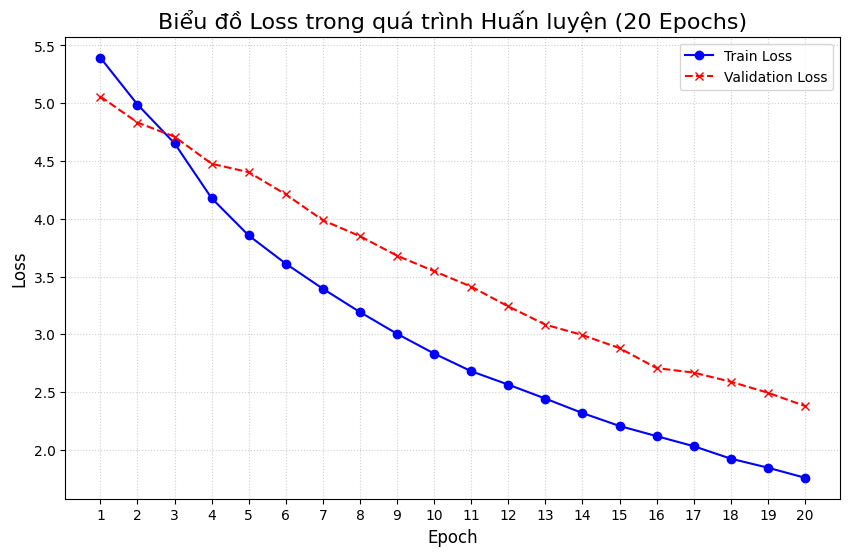

In [31]:
import matplotlib.pyplot as plt
epochs = list(range(1, 21))
train_losses = [
    5.394, 4.989, 4.653, 4.178, 3.855, 
    3.611, 3.394, 3.192, 3.004, 2.833, 
    2.680, 2.564, 2.443, 2.318, 2.206, 
    2.118, 2.031, 1.923, 1.845, 1.758
]
valid_losses = [
    5.058, 4.833, 4.710, 4.476, 4.403, 
    4.211, 3.987, 3.849, 3.680, 3.546, 
    3.412, 3.241, 3.083, 2.993, 2.880, 
    2.707, 2.668, 2.589, 2.494, 2.379
]
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o', linestyle='-')
plt.plot(epochs, valid_losses, label='Validation Loss', color='red', marker='x', linestyle='--')
plt.title('Biểu đồ Loss trong quá trình Huấn luyện (20 Epochs)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs) 
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 7 ví dụ dịch

In [37]:

if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append(os.path.abspath('..'))
    model_save_path = '../checkpoints/best_model.pth'
    val_en_path = '../data/raw/val.en'
    val_fr_path = '../data/raw/val.fr'
else:
    sys.path.append(os.path.abspath('.'))
    model_save_path = 'checkpoints/best_model.pth'
    val_en_path = 'data/raw/val.en'
    val_fr_path = 'data/raw/val.fr'
    from src.evaluate import calculate_bleu_score
    from src.inference import translate
    from src.model import Seq2Seq, Encoder, Decoder 
    from src.data_loader import get_loaders

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.path.exists(model_save_path)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval() 

print("\n" + "="*40)
print("DỊCH THỬ 5 CÂU NGẪU NHIÊN")
print("="*40)

import random

if os.path.exists(val_en_path):
    with open(val_en_path, encoding='utf-8') as f1, open(val_fr_path, encoding='utf-8') as f2:
        val_pairs = list(zip(f1, f2))
    samples = random.sample(val_pairs, 5)
    for src_txt, trg_txt in samples:
        src_txt = src_txt.strip()
        
      
        try:
            pred_tokens = translate(src_txt, model, vocab_en, vocab_fr, device)
            pred_sentence = " ".join(pred_tokens)
            
            print(f"Input:  {src_txt}")
            print(f"Target: {trg_txt.strip()}")
            print(f"Pred:   {pred_sentence.strip()}")
            print("-" * 50)
        except Exception as e:
             print(f"Lỗi dịch câu: {src_txt} | {e}")


DỊCH THỬ 5 CÂU NGẪU NHIÊN
Input:  A young man is skateboarding on a cement block wall.
Target: Un jeune homme fait du skateboard sur un mur de parpaings.
Pred:   Le jeune homme fait du skateboard sur un mur de béton . <eos>
--------------------------------------------------
Input:  A brown dog is running after the black dog.
Target: Un chien brun court après le chien noir.
Pred:   Le chien brun court après un chien brun . <eos>
--------------------------------------------------
Input:  A standing man holds a microphone in front of a man holding a guitar.
Target: Un homme debout tient un micro devant un homme tenant une guitare.
Pred:   Le qu' un homme est debout dans un micro , l' homme d' un guitare . <eos>
--------------------------------------------------
Input:  A mother and two children are posing with funny faces.
Target: Une mère et ses deux enfants posent en faisant de drôles de têtes.
Pred:   La mère et ses enfants enfants avec des cadeaux de Noël . <eos>
--------------------

# 8 Thống kê lỗi từ lạ

In [39]:

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchtext.data.utils import get_tokenizer

try:
    en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
    fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
except:
    print("Chưa load được spacy, dùng hàm split() tạm thời.")
    en_tokenizer = lambda x: x.split()
    fr_tokenizer = lambda x: x.split()
def is_oov(token, vocab):
    UNK_IDX = 0 
    return vocab[token] == UNK_IDX
val_en_path = '../data/raw/val.en' 
val_fr_path = '../data/raw/val.fr'

analysis_data = [] 

if os.path.exists(val_en_path):
    with open(val_en_path, encoding='utf-8') as f1, open(val_fr_path, encoding='utf-8') as f2:
        raw_pairs = list(zip(f1, f2))[:200] # Lấy 200 câu đầu
    model.eval()
    for src_txt, trg_txt in raw_pairs:
        src_txt = src_txt.strip()
        trg_txt = trg_txt.strip()
        try:
            pred_tokens = translate(src_txt, model, vocab_en, vocab_fr, device)
            pred_txt = " ".join(pred_tokens).replace('<eos>', '').strip()
            analysis_data.append((src_txt, trg_txt, pred_txt))
        except:
            continue
else:
    print("Không tìm thấy file dữ liệu val.en!")

Đang phân tích trên 200 câu ví dụ...


In [40]:

print("\n" + "="*60)
print("BÁO CÁO 1: THỐNG KÊ LỖI TỪ LẠ (OOV Analysis)")
print("="*60)

oov_count_en = 0
oov_sentences = 0
total_tokens = 0

print(f"{'Index':<5} | {'Từ lạ (Tiếng Anh)':<20} | {'Máy dịch ra'}")
print("-" * 60)

for i, (src, trg, pred) in enumerate(analysis_data):
    tokens = [t.text.lower() for t in en_tokenizer(src)] if hasattr(en_tokenizer, 'language') else src.lower().split()
    total_tokens += len(tokens)
    
    has_oov = False
    oov_words = []
    for t in tokens:
        if is_oov(t, vocab_en):
            oov_count_en += 1
            oov_words.append(t)
            has_oov = True
            
    if has_oov:
        oov_sentences += 1
        if i < 10: 
            print(f"{i:<5} | {', '.join(oov_words):<20} | {pred[:30]}...")

print("-" * 60)
print(f"->Tổng số từ OOV tìm thấy: {oov_count_en}/{total_tokens} từ ({oov_count_en/total_tokens*100:.2f}%)")
print(f"->Số câu chứa từ lạ: {oov_sentences}/{len(analysis_data)} câu")
print("NHẬN XÉT: " + ("Mô hình gặp khó khăn với từ vựng hiếm." if oov_sentences > 20 else "Bộ từ điển phủ khá tốt."))


BÁO CÁO 1: THỐNG KÊ LỖI TỪ LẠ (OOV Analysis)
Index | Từ lạ (Tiếng Anh)    | Máy dịch ra
------------------------------------------------------------
1     | couch.               | L' homme dormant dans un faute...
2     | woman's, shoulders.  | Le garçon portant des lunettes...
4     | boat.                | Un homme barbu vêtu d' un gile...
5     | coat,, descent,, snapshot. | La femme en manteau rouge tena...
6     | dog.                 | Le chien brun court après un c...
7     | giants, pitch.       | Le jeune garçon portant un cas...
------------------------------------------------------------
->Tổng số từ OOV tìm thấy: 254/2403 từ (10.57%)
->Số câu chứa từ lạ: 192/200 câu
NHẬN XÉT: Mô hình gặp khó khăn với từ vựng hiếm.


# 9 phân tích lỗi theo độ dài câu

In [41]:

print("\n" + "="*60)
print("BÁO CÁO 2: HIỆU SUẤT THEO ĐỘ DÀI CÂU")
print("="*60)

bins = {'Ngắn (<10)': [], 'TB (10-20)': [], 'Dài (>20)': []}

for src, trg, pred in analysis_data:
    length = len(src.split())
    
    ref_set = set(trg.lower().split())
    pred_set = set(pred.lower().split())
    match = len(ref_set.intersection(pred_set))
    precision = match / len(pred_set) if len(pred_set) > 0 else 0
    
    if length < 10: bins['Ngắn (<10)'].append(precision)
    elif length <= 20: bins['TB (10-20)'].append(precision)
    else: bins['Dài (>20)'].append(precision)

print(f"{'Độ dài câu':<15} | {'Số lượng':<10} | {'Độ chính xác từ (Approx)'}")
print("-" * 60)
for label, scores in bins.items():
    avg_score = sum(scores)/len(scores) if scores else 0
    print(f"{label:<15} | {len(scores):<10} | {avg_score*100:.2f}%")

print("-" * 60)
print("NHẬN XÉT: Thông thường câu càng dài, độ chính xác càng giảm do hạn chế của Context Vector.")


BÁO CÁO 2: HIỆU SUẤT THEO ĐỘ DÀI CÂU
Độ dài câu      | Số lượng   | Độ chính xác từ (Approx)
------------------------------------------------------------
Ngắn (<10)      | 59         | 41.60%
TB (10-20)      | 133        | 46.76%
Dài (>20)       | 8          | 41.32%
------------------------------------------------------------
NHẬN XÉT: Thông thường câu càng dài, độ chính xác càng giảm do hạn chế của Context Vector.


# 10 phân tích loại lỗi

In [42]:

print("\n" + "="*60)
print("BÁO CÁO 3: PHÂN LOẠI LỖI DỊCH THUẬT")
print("="*60)

err_missing = 0 # Thiếu từ
err_extra = 0   # Thừa từ
err_sub = 0     # Sai từ

print("Ví dụ chi tiết 3 trường hợp lỗi:")
print("-" * 60)

for i, (src, trg, pred) in enumerate(analysis_data):
    ref_tokens = set(trg.lower().split())
    pred_tokens = set(pred.lower().split())
    
    missing = ref_tokens - pred_tokens
    extra = pred_tokens - ref_tokens
    
    if len(missing) > 0: err_missing += 1
    if len(extra) > 0: err_extra += 1
    if i < 3:
        print(f"Câu {i+1}:")
        print(f"🇬🇧 Input: {src}")
        print(f"Target: {trg}")
        print(f"Pred:   {pred}")
        if missing: print(f"  Thiếu từ: {', '.join(list(missing)[:3])}")
        if extra:   print(f"  Thừa từ: {', '.join(list(extra)[:3])}")
        print("-" * 30)

print(f"Tổng kết trên {len(analysis_data)} câu:")
print(f"   - Số câu bị thiếu từ (Omission): {err_missing} câu")
print(f"   - Số câu bị thừa từ (Insertion): {err_extra} câu")


BÁO CÁO 3: PHÂN LOẠI LỖI DỊCH THUẬT
Ví dụ chi tiết 3 trường hợp lỗi:
------------------------------------------------------------
Câu 1:
🇬🇧 Input: A group of men are loading cotton onto a truck
Target: Un groupe d'hommes chargent du coton dans un camion
Pred:   Les groupe d' hommes font un un toit d' un camion
  Thiếu từ: dans, d'hommes, du
  Thừa từ: hommes, les, font
------------------------------
Câu 2:
🇬🇧 Input: A man sleeping in a green room on a couch.
Target: Un homme dormant dans une chambre verte sur un canapé.
Pred:   L' homme dormant dans un fauteuil en plastique dans un fauteuil .
  Thiếu từ: une, verte, sur
  Thừa từ: en, plastique, l'
------------------------------
Câu 3:
🇬🇧 Input: A boy wearing headphones sits on a woman's shoulders.
Target: Un garçon avec un casque est assis sur les épaules d'une femme.
Pred:   Le garçon portant des lunettes est assis sur la épaules d' une femme .
  Thiếu từ: casque, d'une, les
  Thừa từ: une, la, d'
------------------------------
Tổng